## Intro to using beautiful soup to scrape web football data

### Install Beautiful Soup

In [ ]:
# pip install beautifulsoup4


## We will now want to import all the necessary packages require for scraping and analysis:

In [1]:
import requests
import json
from mobfot import MobFot

import pandas as pd
from bs4 import BeautifulSoup
# import klib as kb
import seaborn as sb
import matplotlib.pyplot as plt
# import wes
import matplotlib as mpl
import warnings
import numpy as np
from math import pi
from urllib.request import urlopen
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from sklearn.preprocessing import StandardScaler


In [2]:
EPL_Player_db = pd.read_csv('CSVs/EPL_Player_Database.csv')

In [3]:
position = 'Central Midfielders'
pl_starts = 10
max_age = 32

subset_of_data = EPL_Player_db.query('position_group == @position & Starts > @pl_starts & Age < @max_age' )
players_needed = list(subset_of_data.urls.unique())

In [46]:
def get_player_multi_data(url_list:list):
    appended_data = []
    for url in url_list:
        warnings.filterwarnings("ignore")
        page =requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        name = [element.text for element in soup.find_all("span")]
        name = name[7]
        metric_names = []
        metric_values = []
        remove_content = ["'", "[", "]", ","]
        for row in soup.findAll('table')[0].tbody.findAll('tr'):
            first_column = row.findAll('th')[0].contents
            metric_names.append(first_column)
        for row in soup.findAll('table')[0].tbody.findAll('tr'):
            first_column = row.findAll('td')[0].contents
            metric_values.append(first_column)

        metric_names = [item for sublist in metric_names for item in sublist]
        metric_values = [item for sublist in metric_values for item in sublist]

        df_player = pd.DataFrame()
        df_player['Name'] = name[0]
        for item in metric_names:
            df_player[item] = []

        name = name
        non_penalty_goals = (metric_values[0])
        npx_g = metric_values[1]
        shots_total = metric_values[2]
        assists = metric_values[3]
        x_a = metric_values[4]
        npx_g_plus_x_a = metric_values[5] 
        shot_creating_actions = metric_values[6] 
        passes_attempted = metric_values[7] 
        pass_completion_percent = metric_values[8] 
        progressive_passes = metric_values[9] 
        progressive_carries = metric_values[10] 
        successful_take_ons = metric_values[11] 
        touches_att_pen = metric_values[12]
        progressive_passes_rec = metric_values[13] 
        tackles = metric_values[14] 
        interceptions = metric_values[15] 
        blocks = metric_values[16]
        clearances = metric_values[17]
        aerials_won = metric_values[18]
        df_player.loc[0] = [name, non_penalty_goals, npx_g, shots_total, assists, x_a, npx_g_plus_x_a, shot_creating_actions, passes_attempted, pass_completion_percent,
                            progressive_passes, progressive_carries, successful_take_ons, touches_att_pen, progressive_passes_rec, tackles, interceptions, blocks,
                            clearances, aerials_won]
        appended_data.append(df_player)
    appended_data = pd.concat(appended_data)
    return appended_data

In [47]:
df = get_player_multi_data(players_needed)

IndexError: list index out of range

In [ ]:
df= df.reset_index(drop=True)


AttributeError: 'YAxis' object has no attribute 'set_rotate_label'

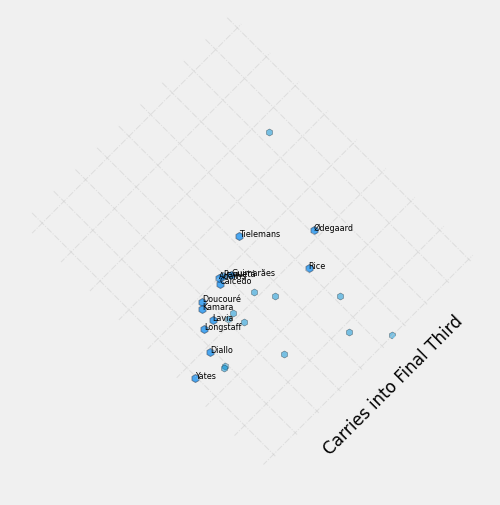

In [55]:

df = df[["Name", "Progressive Carries", "Progressive Passes"]]

# df[["Carries_1/3", "1/3"]] = df[["Carries_1/3", "1/3"]].div(df["90s"], axis=0)
df = df 
xs = StandardScaler().fit_transform(df["Progressive Carries"].values.reshape(-1, 1))
ys = StandardScaler().fit_transform(df["Progressive Passes"].values.reshape(-1, 1))

with plt.style.context("fivethirtyeight"):
    fig = plt.figure(figsize=(8,8))
   
    plot_extents = min(xs)[0]-1, max(xs)[0]+1, min(ys)[0]-1, max(ys)[0]+1
    transform = Affine2D().rotate_deg(45)
    helper = floating_axes.GridHelperCurveLinear(transform, plot_extents)
    ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper)
    ax.grid(alpha=0.5, linestyle="-.")
    fig.add_subplot(ax)

    ax.scatter(xs, ys, ec='k', alpha=.5, s=50, marker="h")
    ax.set_aspect(1)

    ###highlight top percentile players
    player_names = list(set(df.sort_values("Progressive Carries")["Name"].head(7).tolist() + df.sort_values("Progressive Passes")["Name"].tail(7).tolist()))

    sel_df = df.query("Name == @player_names")
    sel_idx = sel_df.index; player_names = sel_df.Name.tolist()
    sel_xs = xs[sel_idx]; sel_ys = ys[sel_idx]

    ax.scatter(sel_xs, sel_ys, color="dodgerblue", ec="k", alpha=.5, s=70, marker="h")
    for name, x, y in zip(player_names, sel_xs,sel_ys ):
        ax.text(x, y, name.split(" ")[-1], fontsize=8)
    ax.axis[:].major_ticklabels.set_alpha(0)

    ax.set(xlabel="Carries into Final Third")
    ax.set(ylabel="Passes into Final Third")
    fig.text(x=0.5, y=0.95, s="Ball Progression Profile", fontsize=18, fontweight="light", ha="center")
    fig.text(x=0.5, y=0.9, s= f"English Premier League | Position: Midfielders | Minimum Starts: {pl_starts}", 
        fontsize=12, fontweight="light", ha="center")

fig.savefig("diamond_plot.png", dpi=180)
plt.show()

In [4]:
team_table = pd.read_csv("CSVs/EPL_Teams_URLs.csv")
team_table = team_table[["team_names","urls"]]

def get_wages(url):    
    start = url[0:37]+ "2022-2023/wages/"
    def remove_first_n_char(org_str, n):
        mod_string = ""
        for i in range(n, len(org_str)):
            mod_string = mod_string + org_str[i]
        return mod_string
    mod_string = remove_first_n_char(url, 37)
    final_string = start+mod_string+"-Wage-Details"   
    return final_string

team_table['wages'] = team_table.apply(lambda x: get_wages(x['urls']), axis=1)

team_table

,team_names,urls,wages
0,Manchester-United,https://fbref.com/en/squads/19538871/Mancheste...,https://fbref.com/en/squads/19538871/2022-2023...
1,Leeds-United,https://fbref.com/en/squads/5bfb9659/Leeds-Uni...,https://fbref.com/en/squads/5bfb9659/2022-2023...
2,Leicester-City,https://fbref.com/en/squads/a2d435b3/Leicester...,https://fbref.com/en/squads/a2d435b3/2022-2023...
3,Fulham,https://fbref.com/en/squads/fd962109/Fulham-Stats,https://fbref.com/en/squads/fd962109/2022-2023...
4,West-Ham-United,https://fbref.com/en/squads/7c21e445/West-Ham-...,https://fbref.com/en/squads/7c21e445/2022-2023...
5,Nottingham-Forest,https://fbref.com/en/squads/e4a775cb/Nottingha...,https://fbref.com/en/squads/e4a775cb/2022-2023...
6,Arsenal,https://fbref.com/en/squads/18bb7c10/Arsenal-S...,https://fbref.com/en/squads/18bb7c10/2022-2023...
7,Bournemouth,https://fbref.com/en/squads/4ba7cbea/Bournemou...,https://fbref.com/en/squads/4ba7cbea/2022-2023...
8,Newcastle-United,https://fbref.com/en/squads/b2b47a98/Newcastle...,https://fbref.com/en/squads/b2b47a98/2022-2023...
9,Brentford,https://fbref.com/en/squads/cd051869/Brentford...,https://fbref.com/en/squads/cd051869/2022-2023...


In [440]:
import time
def league_wages_df(match_links):
    data_append = []
    for x in match_links:
        print(x)
        warnings.filterwarnings("ignore")
        url = x
        page =requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        name = [element.text for element in soup.find_all("span")]
        name = name[7]
        # name = name[10:]

        # Remove last 17 characters
        name = name[:-17]
        html_content = requests.get(url).text.replace('<!--', '').replace('-->', '')
        df = pd.read_html(html_content)
        wage_stats = df[0]
        def remove_nan_rows(df, column_name):
            df.dropna(subset=[column_name], inplace=True)
            return df
        wage_stats = remove_nan_rows(wage_stats, "Weekly Wages")
        def extract_currency_values(column_value):
            parts = column_value.split(" ")
            pound_value = parts[0] + "  " + parts[1]
            euro_value = parts[3]
            dollar_value = parts[4]
            return pound_value, euro_value, dollar_value

        wage_stats[["Pound Value", "Euro Value", "Dollar Value"]] = wage_stats["Weekly Wages"].apply(extract_currency_values).apply(pd.Series)
        def convert_pound_values_to_int(df, column_name):
            df['new_pound_value'] = df[column_name].str.replace('£', '').str.replace(',', '').astype(int)
            return df
        wage_stats = convert_pound_values_to_int(wage_stats, "Pound Value")
        wage_stats = wage_stats[["Player", "Nation","Pos","Age","new_pound_value"]]
        # wage_stats['Player'] = name
        data_append.append(wage_stats)
        del df, soup
        time.sleep(10)
    df_total = pd.concat(data_append)

    return df_total

In [441]:
match_links = list(team_table.wages.unique())
wages_df = league_wages_df(match_links)
wages_df.to_csv("CSVs/EPL_Player_Wages.csv")

https://fbref.com/en/squads/19538871/2022-2023/wages/Manchester-United-Stats-Wage-Details
https://fbref.com/en/squads/5bfb9659/2022-2023/wages/Leeds-United-Stats-Wage-Details
https://fbref.com/en/squads/a2d435b3/2022-2023/wages/Leicester-City-Stats-Wage-Details
https://fbref.com/en/squads/fd962109/2022-2023/wages/Fulham-Stats-Wage-Details
https://fbref.com/en/squads/7c21e445/2022-2023/wages/West-Ham-United-Stats-Wage-Details
https://fbref.com/en/squads/e4a775cb/2022-2023/wages/Nottingham-Forest-Stats-Wage-Details
https://fbref.com/en/squads/18bb7c10/2022-2023/wages/Arsenal-Stats-Wage-Details
https://fbref.com/en/squads/4ba7cbea/2022-2023/wages/Bournemouth-Stats-Wage-Details
https://fbref.com/en/squads/b2b47a98/2022-2023/wages/Newcastle-United-Stats-Wage-Details
https://fbref.com/en/squads/cd051869/2022-2023/wages/Brentford-Stats-Wage-Details
https://fbref.com/en/squads/33c895d4/2022-2023/wages/Southampton-Stats-Wage-Details
https://fbref.com/en/squads/d07537b9/2022-2023/wages/Brighton-

In [7]:
import re
team_ids = pd.read_csv("CSVs/fotmob_epl_team_ids.csv")
client = MobFot()

def get_epl_ratings(team_ids):
    dataframes = []
    for t_id in team_ids.team_id.unique():
        dict1 = client.get_team(t_id)

        def extract_names_and_urls(data):
            names = []
            urls = []
            for athlete in data['details']['sportsTeamJSONLD']['athlete']:
                names.append(athlete['name'])
                urls.append(athlete['url'])
            df = pd.DataFrame({'Name': names, 'URL': urls})
            return df

        player_rating = extract_names_and_urls(dict1)

        fm_ratings = []
        player_ids = (player_rating.URL.unique())
        def extract_rating(player_ids):
            for id in player_ids:
                print(id)
                numbers = re.findall(r'\d+', id)
                id = ''.join(numbers)
                dict2 = client.get_player(id)
                l1= dict2['careerStatistics']
                def get_fotmob_rating(data, seasonid):
                    if data == None:
                        fm_ratings.append(None)
                    else:
                        for league in data:
                            for season in league['seasons']:
                                if season['seasonId'] == seasonid:
                                    for stat in season['stats'][0]['statsArr']:
                                        if stat[0] == 'FotMob rating':
                                            return stat[1]['value']['num']
                    return None
                rating = get_fotmob_rating(l1, 879290)  
                fm_ratings.append(rating)  # Append None if rating is not found

            return(fm_ratings)

        table = extract_names_and_urls(dict1)
        fm_ratings = extract_rating(player_ids)
        fm_ratings = fm_ratings[:len(table)]

        # Create a DataFrame with the player_ids and fm_ratings
        df2 = pd.DataFrame({'URL': player_ids, 'ratings': fm_ratings})

        # Merge the DataFrame with the original data using player_id as the key
        new_table = table.merge(df2, on='URL', how='left')

        new_table['team_id'] = t_id
        dataframes.append(new_table)
    final = pd.concat(dataframes)

    return final


In [8]:
epl_player_ratings = get_epl_ratings(team_ids)

https://www.fotmob.com/players/36283/wayne-hennessey
https://www.fotmob.com/players/51949/keylor-navas
https://www.fotmob.com/players/719330/dean-henderson
https://www.fotmob.com/players/156013/steve-cook
https://www.fotmob.com/players/195299/serge-aurier
https://www.fotmob.com/players/246331/willy-boly
https://www.fotmob.com/players/268212/felipe
https://www.fotmob.com/players/551805/scott-mckenna
https://www.fotmob.com/players/575804/harry-toffolo
https://www.fotmob.com/players/592102/moussa-niakhat
https://www.fotmob.com/players/716687/joe-worrall
https://www.fotmob.com/players/793876/renan-lodi
https://www.fotmob.com/players/798608/omar-richards
https://www.fotmob.com/players/990989/giulian-biancone
https://www.fotmob.com/players/1078788/neco-williams
https://www.fotmob.com/players/95955/andr-ayew
https://www.fotmob.com/players/127130/jonjo-shelvey
https://www.fotmob.com/players/148302/cheikhou-kouyat
https://www.fotmob.com/players/155129/harry-arter
https://www.fotmob.com/players/

In [445]:
epl_player_ratings.to_csv("Current_EPL_player_ratings.csv")

In [9]:
wages_df = pd.read_csv("CSVs/EPL_Player_Wages.csv")

In [10]:
wages_df.rename(columns={'Player': 'Name'}, inplace=True)

In [11]:
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def get_approximate_match(query, choices):
    return process.extractOne(query, choices)[0]

# Create a dictionary to store approximate matches
name_mapping = {}

# Loop through each name in wages dataframe
for name in wages_df['Name']:
    # Find approximate match in epl_player_ratings dataframe
    match = get_approximate_match(name, epl_player_ratings['Name'])
    # Store the approximate match in the dictionary
    name_mapping[name] = match

# Replace the 'Name' column in wages dataframe with the approximate match
wages_df['Name'] = wages_df['Name'].map(name_mapping)

# Perform left join on 'Name' column
merged_df = pd.merge(wages_df, epl_player_ratings, on='Name', how='left')

merged_df.drop('Unnamed: 0_y', axis=1, inplace=True)
merged_df.drop('Unnamed: 0_x', axis=1, inplace=True)

# Remove rows with NaN values in 'Nation' column
merged_df.dropna(subset=['Nation'], inplace=True)


/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


KeyError: "['Unnamed: 0_y'] not found in axis"

In [15]:
merged_df

,Name,Nation,Pos,Age,new_pound_value,URL,ratings,team_id
0,Cristian Romero,pt POR,FW,37.0,515000,https://www.fotmob.com/players/789066/cristian...,6.91,8586
1,David De Gea,es ESP,GK,31.0,375000,https://www.fotmob.com/players/182917/david-de...,6.73,10260
2,Jadon Sancho,eng ENG,"FW,MF",22.0,350000,https://www.fotmob.com/players/846381/jadon-sa...,7.26,10260
3,Raphaël Varane,fr FRA,DF,29.0,340000,https://www.fotmob.com/players/230982/raphal-v...,6.83,10260
4,Casemiro,br BRA,MF,30.0,300000,https://www.fotmob.com/players/208494/casemiro,7.28,10260
5,Anthony Martial,fr FRA,FW,26.0,250000,https://www.fotmob.com/players/413557/anthony-...,6.88,10260
6,Bruno Fernandes,pt POR,"MF,FW",27.0,240000,https://www.fotmob.com/players/422685/bruno-fe...,7.72,10260
7,Antony,br BRA,FW,22.0,200000,https://www.fotmob.com/players/967622/antony,7.28,10260
8,Marcus Rashford,eng ENG,FW,24.0,200000,https://www.fotmob.com/players/696365/marcus-r...,7.32,10260
9,Harry Maguire,eng ENG,DF,29.0,190000,https://www.fotmob.com/players/255610/harry-ma...,6.99,10260


In [64]:
t_id = 9825
filtered_df = merged_df[merged_df['team_id'] == 9825]
filtered_df['player_id'] = filtered_df['URL'].str.extract(r'(\d+)')
filtered_df = filtered_df[filtered_df['ratings'].notna()]

total_wages = filtered_df['new_pound_value'].sum()

# Calculate wage contribution percentage
filtered_df['wage_contribution'] = (filtered_df['new_pound_value'] / total_wages)
filtered_df

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Name,Nation,Pos,Age,new_pound_value,URL,ratings,team_id,player_id,wage_contribution
160,Gabriel Jesus,br BRA,FW,25.0,265000,https://www.fotmob.com/players/576165/gabriel-...,7.53,9825,576165,0.140212
161,Thomas Partey,gh GHA,MF,29.0,200000,https://www.fotmob.com/players/434325/thomas-p...,7.72,9825,434325,0.105820
162,Oleksandr Zinchenko,ua UKR,DF,25.0,150000,https://www.fotmob.com/players/623621/oleksand...,7.32,9825,623621,0.079365
163,Ben White,eng ENG,DF,24.0,120000,https://www.fotmob.com/players/776151/ben-white,7.28,9825,776151,0.063492
164,Granit Xhaka,ch SUI,MF,29.0,120000,https://www.fotmob.com/players/207236/granit-x...,7.44,9825,207236,0.063492
165,Martin Ødegaard,no NOR,MF,23.0,115000,https://www.fotmob.com/players/534670/martin-d...,7.71,9825,534670,0.060847
166,Kieran Tierney,sct SCO,DF,25.0,110000,https://www.fotmob.com/players/582499/kieran-t...,6.63,9825,582499,0.058201
167,Edward Nketiah,eng ENG,FW,23.0,100000,https://www.fotmob.com/players/860920/edward-n...,6.74,9825,860920,0.052910
168,Gabriel Martinelli,br BRA,FW,21.0,90000,https://www.fotmob.com/players/1021586/gabriel...,7.53,9825,1021586,0.047619
170,Bukayo Saka,eng ENG,FW,20.0,70000,https://www.fotmob.com/players/961995/bukayo-saka,7.79,9825,961995,0.037037


In [18]:
from PIL import Image
import urllib
import matplotlib.patheffects as path_effects

from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from matplotlib import cm
from highlight_text import fig_text, ax_text
from ast import literal_eval

# -- For Logos and images
from matplotlib.transforms import Bbox
class BboxLocator:
    def __init__(self, bbox, transform):
        self._bbox = bbox
        self._transform = transform
    def __call__(self, ax, renderer):
        _bbox = self._transform.transform_bbox(self._bbox)
        return ax.figure.transFigure.inverted().transform_bbox(_bbox)

def draw_player_image_at_ax(player_id, ax, grayscale=False):
    '''
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/playerimages/'
    club_icon = Image.open(urllib.request.urlopen(F'{fotmob_url}{player_id}.png'))
    if grayscale:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

def draw_club_image_at_ax(team_id, ax, grayscale=False):
    '''
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id}.png'))
    if grayscale:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

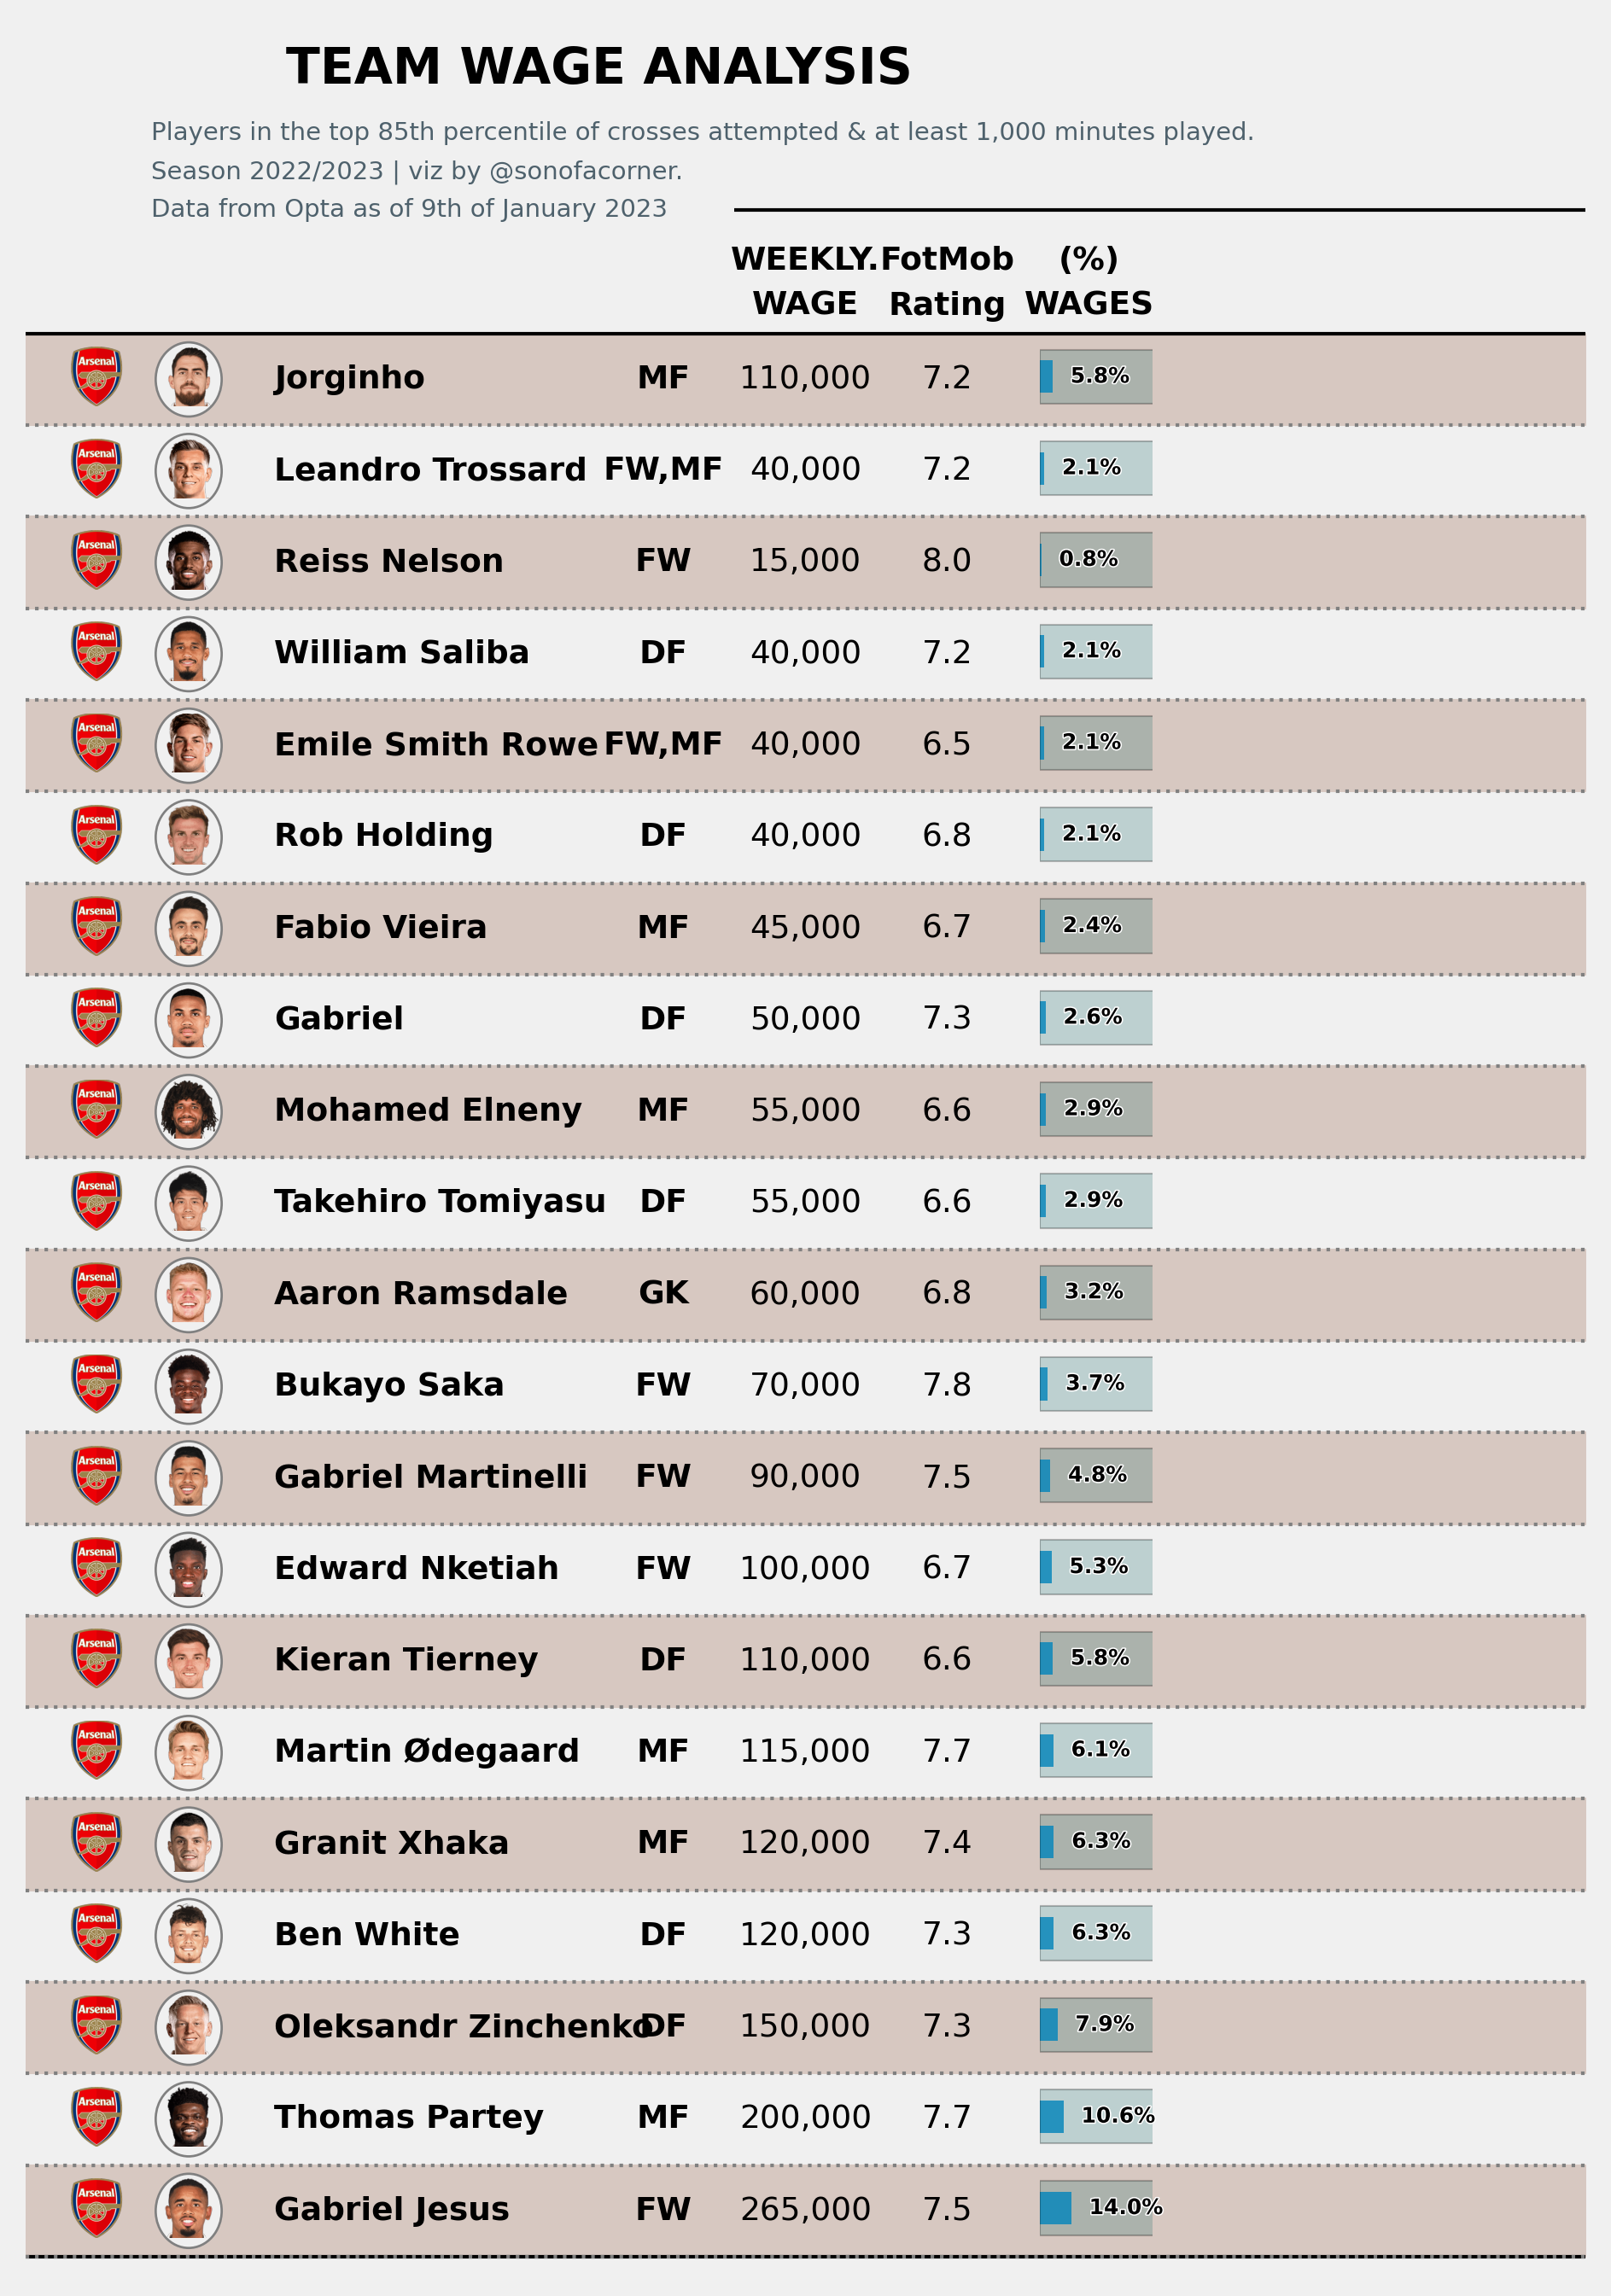

In [120]:
fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()

nrows = filtered_df.shape[0]
ncols = filtered_df.shape[1] - 3 # because I want to remove aprox. 3 columns from my DF

ax.set_xlim(0, ncols + 1)
ax.set_ylim(-.65, nrows + 1)

# calculate asymmetry of x and y axes: (I have no idea how this works)
x0, y0 = ax.transAxes.transform((0, 0)) # lower left in pixels
x1, y1 = ax.transAxes.transform((1, 1)) # upper right in pixes
dx = x1 - x0
dy = y1 - y0
maxd = max(dx, dy)
width = .35 * maxd / dx
height = .81 * maxd / dy

# Iterate
for y in range(0, nrows):
    # -- Club Logo
    bbox = Bbox.from_bounds(0, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_club_image_at_ax(filtered_df['team_id'].iloc[y], logo_ax)
    # -- Player picture
    circle = Ellipse((1.15, y), width, height, ec='grey', fc=fig.get_facecolor(), transform=ax.transData, lw=.65)
    bbox = Bbox.from_bounds(.65, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_player_image_at_ax(filtered_df['player_id'].iloc[y], logo_ax)
    ax.add_artist(circle)
    # -- Player name
    ax_text(
        x=1.75, y=y,
        s=filtered_df['Name'].iloc[y],
        weight='bold', size=9,
        ha='left', va='center', ax=ax, family='Karla'
    )
    # -- Player position
    ax_text(
        x=4.5, y=y,
        s=filtered_df['Pos'].iloc[y],
        weight='bold', size=9,
        ha='center', va='center', ax=ax
    )
    # -- Minutes played
    ax_text(
        x=5.5, y=y,
        s=f"{filtered_df['new_pound_value'].iloc[y]:,.0f}",
        size=9,
        ha='center', va='center', ax=ax
    )
    # # -- Crosses
    ax_text(
        x=6.5, y=y,
        s=f"{filtered_df['ratings'].iloc[y]:,.1f}",
        size=9,
        ha='center', va='center', ax=ax
    )
    # # -- Battery Chart
    bbox = Bbox.from_bounds(7.15, y - .295, 0.8, .65)
    battery_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    battery_ax.set_xlim(0,0.5)
    battery_ax.barh(y=.5, width=filtered_df['wage_contribution'].iloc[y], height=.3, alpha=.85)
    battery_ax.barh(y=.5, width=1, height=.5, alpha=.25, color='#287271', ec='black')
    text_ = battery_ax.annotate(
        xy=(filtered_df['wage_contribution'].iloc[y], .5),
        xytext=(5,0),
        textcoords='offset points',
        text=f"{filtered_df['wage_contribution'].iloc[y]:.1%}",
        ha='left', va='center',
        size=6, weight='bold'
    )
    text_.set_path_effects(
                [path_effects.Stroke(linewidth=.75, foreground="white"), 
                path_effects.Normal()]
            )
    battery_ax.set_axis_off()
    

# -- Draw border lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows - .5, nrows - .5], lw=1, color='black', zorder=3)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [-.5, -.5], lw=1, color='black', zorder=3)
for x in range(nrows):
    if x % 2 == 0:
        ax.fill_between(x=[ax.get_xlim()[0], ax.get_xlim()[1]], y1=x-.5, y2=x+.5, color='#d7c8c1', zorder=-1)
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x - .5, x - .5], lw=1, color='grey', ls=':', zorder=3)

ax.set_axis_off()


# -- Column titles
ax_text(
    x=5.5, y=nrows + .05,
    s='WEEKLY.\nWAGE',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)
ax_text(
    x=6.5, y=nrows + .05,
    s='FotMob\nRating',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)
ax_text(
    x=7.5, y=nrows + .05,
    s='(%)\nWAGES',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)

ax.plot([5, ax.get_xlim()[1]], [nrows + .85, nrows + .85], lw=1, color='black', zorder=3)

fig_text(
    x = 0.4, y = .92, 
    s = "TEAM WAGE ANALYSIS",
    va = "bottom", ha = "center",
    fontsize = 14, color = "black", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.15, y = .87, 
    s = "Players in the top 85th percentile of crosses attempted & at least 1,000 minutes played.\nSeason 2022/2023 | viz by @sonofacorner.\nData from Opta as of 9th of January 2023",
	va = "bottom", ha = "left",
	fontsize = 7, color = "#4E616C", font = "DM Sans"
)

# plt.savefig(
# 	"figures/01092023_epl_crosses.png",
# 	dpi = 600,
# 	facecolor = "#EFE9E6",
# 	bbox_inches="tight",
#     edgecolor="none",
# 	transparent = False
# )

# plt.savefig(
# 	"figures/01092023_epl_crosses_tr.png",
# 	dpi = 600,
# 	facecolor = "none",
# 	bbox_inches="tight",
#     edgecolor="none",
# 	transparent = True
# )

In [65]:
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import scipy.stats as stats

filtered_df['new_pound_value_2'] = filtered_df['new_pound_value']/1000

filtered_df['zscore'] = stats.zscore(filtered_df['new_pound_value_2'])*1 + stats.zscore(filtered_df['ratings'])*1
filtered_df['annotated'] = [True if x > filtered_df['zscore'].quantile(0) else False for x in filtered_df['zscore']]


def pound_formatter(x, pos):
    return f'£{x/1000:.0f}K'

In [66]:
filtered_df

,Name,Nation,Pos,Age,new_pound_value,URL,ratings,team_id,player_id,wage_contribution,new_pound_value_2,zscore,annotated
160,Gabriel Jesus,br BRA,FW,25.0,265000,https://www.fotmob.com/players/576165/gabriel-...,7.53,9825,576165,0.140212,265.0,3.777839,True
161,Thomas Partey,gh GHA,MF,29.0,200000,https://www.fotmob.com/players/434325/thomas-p...,7.72,9825,434325,0.105820,200.0,3.101973,True
162,Oleksandr Zinchenko,ua UKR,DF,25.0,150000,https://www.fotmob.com/players/623621/oleksand...,7.32,9825,623621,0.079365,150.0,1.348219,True
163,Ben White,eng ENG,DF,24.0,120000,https://www.fotmob.com/players/776151/ben-white,7.28,9825,776151,0.063492,120.0,0.747802,True
164,Granit Xhaka,ch SUI,MF,29.0,120000,https://www.fotmob.com/players/207236/granit-x...,7.44,9825,207236,0.063492,120.0,1.109270,True
165,Martin Ødegaard,no NOR,MF,23.0,115000,https://www.fotmob.com/players/534670/martin-d...,7.71,9825,534670,0.060847,115.0,1.634238,True
166,Kieran Tierney,sct SCO,DF,25.0,110000,https://www.fotmob.com/players/582499/kieran-t...,6.63,9825,582499,0.058201,110.0,-0.890679,True
167,Edward Nketiah,eng ENG,FW,23.0,100000,https://www.fotmob.com/players/860920/edward-n...,6.74,9825,860920,0.052910,100.0,-0.812186,True
168,Gabriel Martinelli,br BRA,FW,21.0,90000,https://www.fotmob.com/players/1021586/gabriel...,7.53,9825,1021586,0.047619,90.0,0.802545,True
170,Bukayo Saka,eng ENG,FW,20.0,70000,https://www.fotmob.com/players/961995/bukayo-saka,7.79,9825,961995,0.037037,70.0,1.049897,True


/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  app.launch_new_instance()
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  app.launch_new_instance()


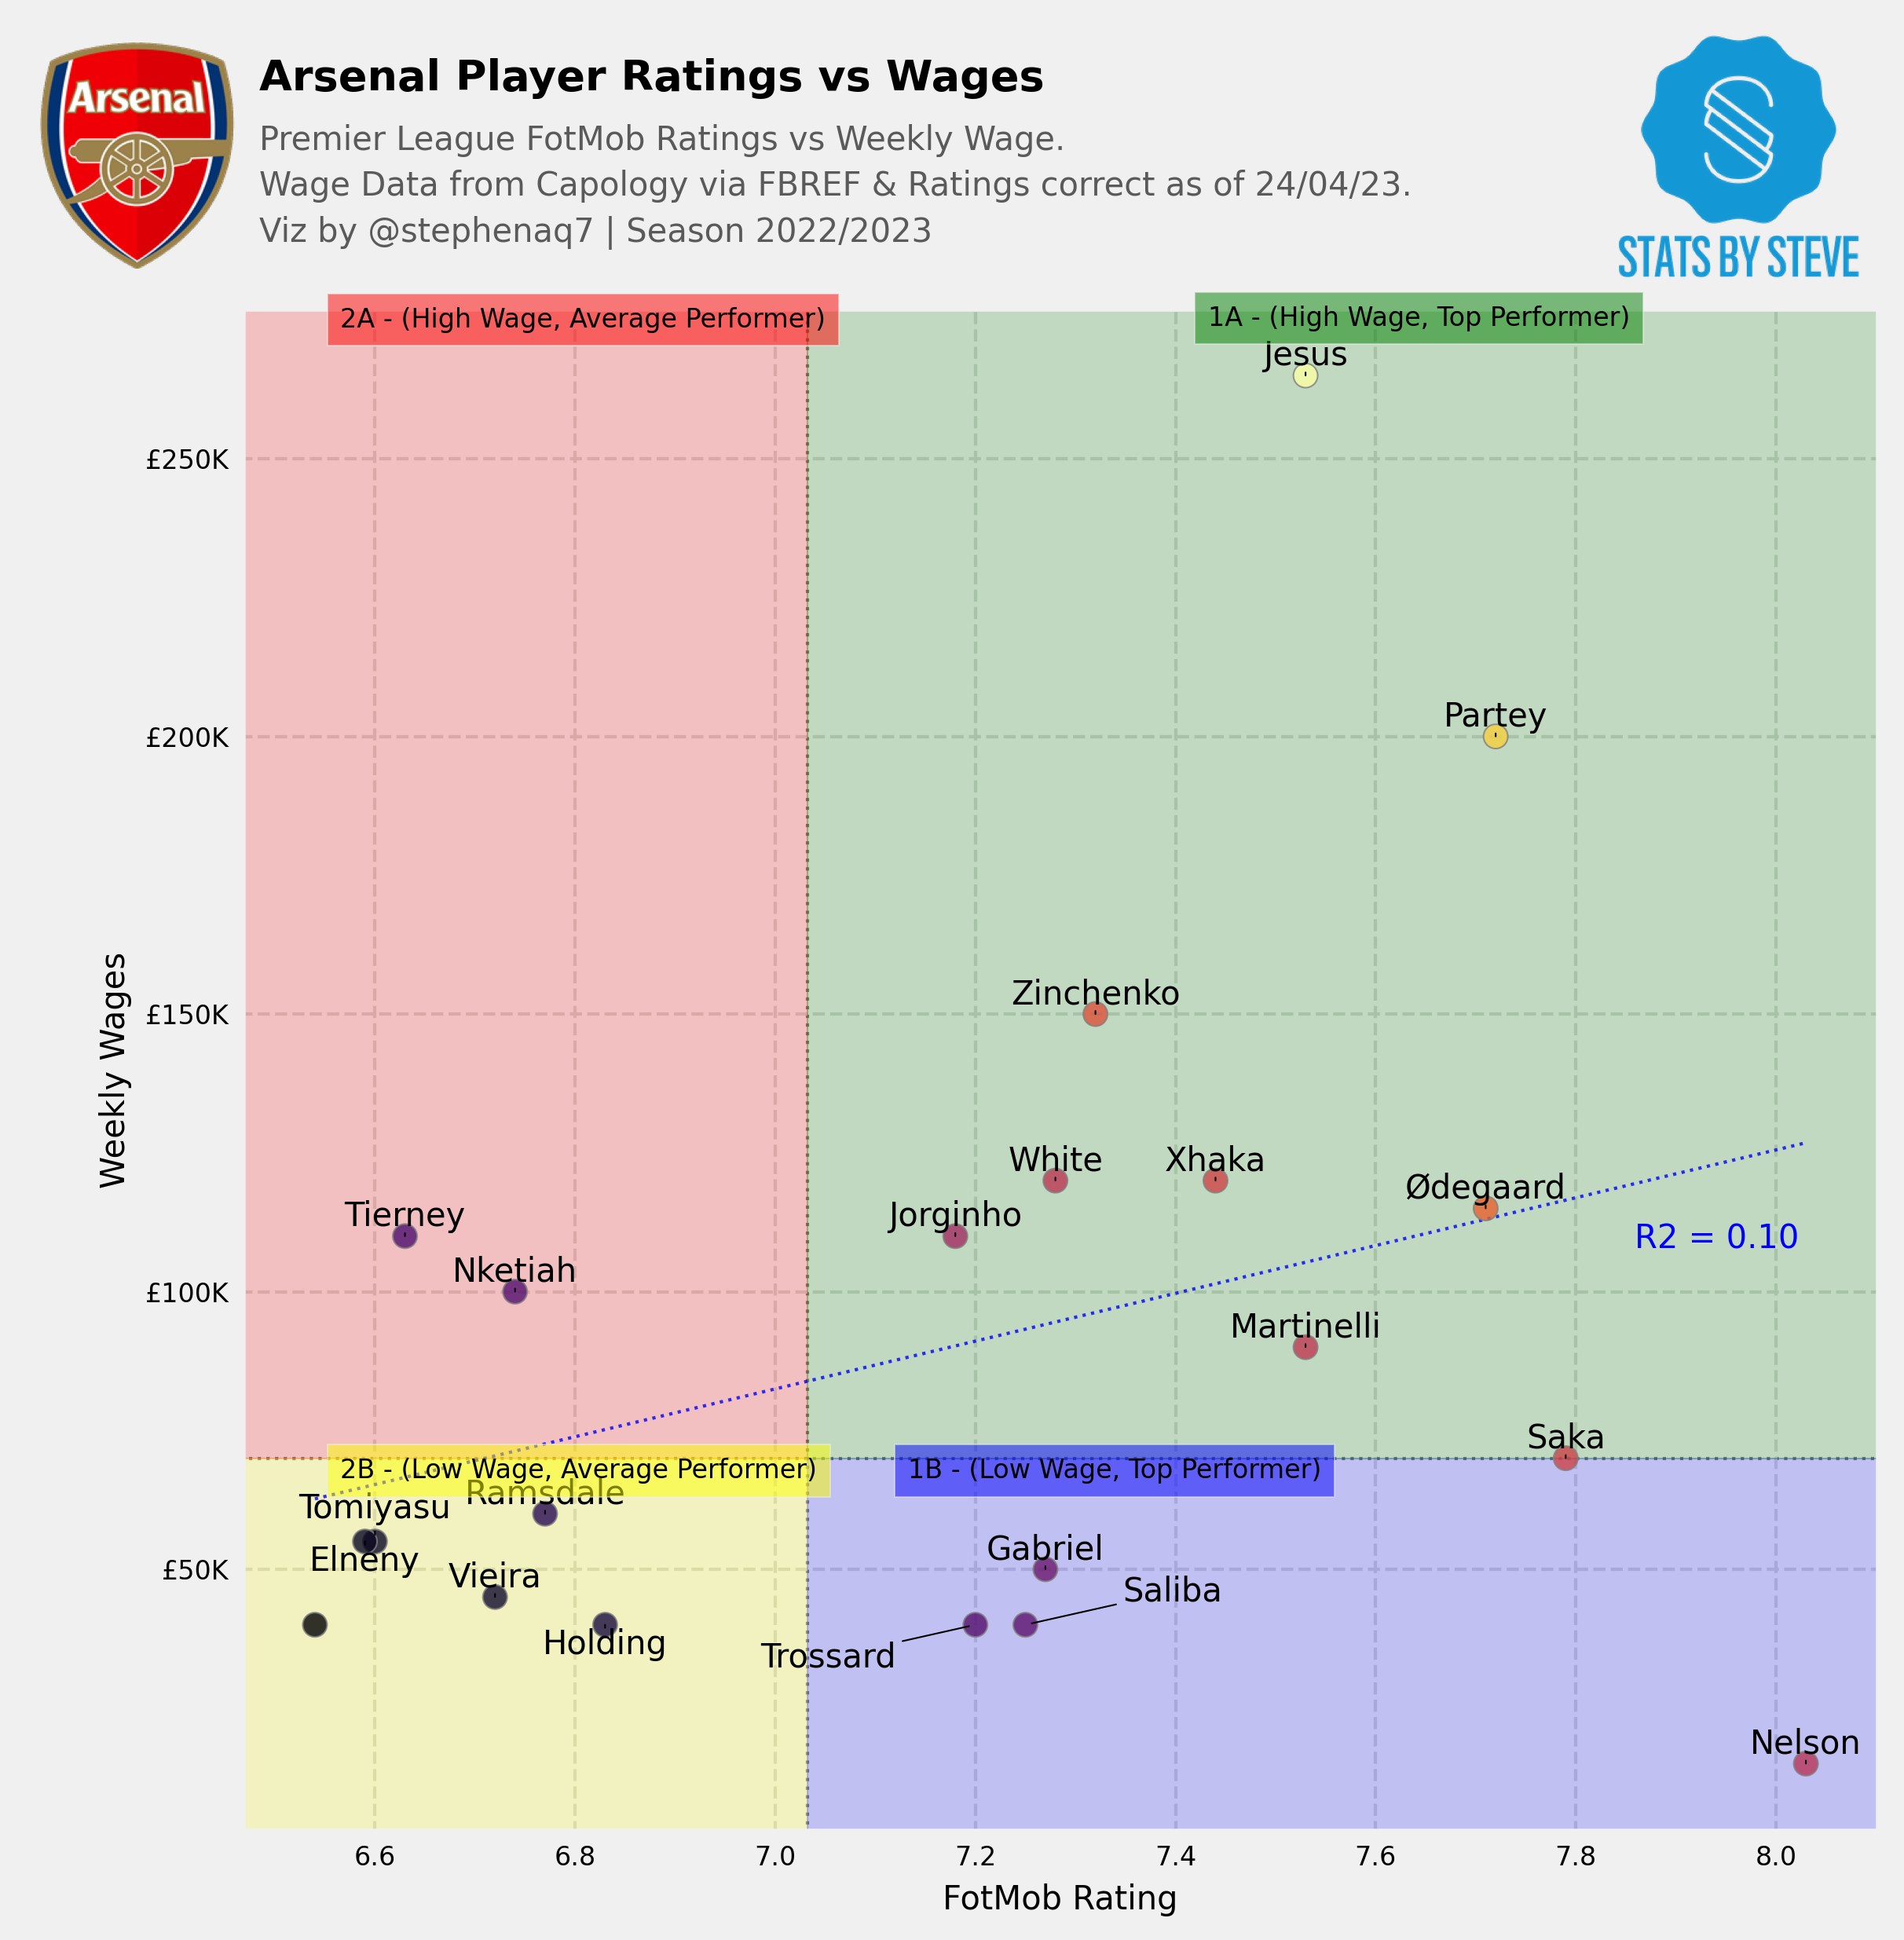

In [147]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.image as image
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
from adjustText import adjust_text
import math

# Define a custom formatter for y-axis tick labels
max_ = max(abs(filtered_df['new_pound_value_2'].min()), filtered_df['new_pound_value_2'].max())

fig = plt.figure(figsize=(8, 8), dpi=300)
ax = plt.subplot()
ax.grid(visible=False, ls='--', color='lightgrey')

# Define quadrants based on median values of 'ratings' and 'new_pound_value_2'
median_ratings = ((filtered_df['ratings'].median())*0.97)
median_wages = filtered_df['new_pound_value_2'].median()

# Plot scatter points for each quadrant
scatter = ax.scatter(
    filtered_df['ratings'], filtered_df['new_pound_value_2'],
    c=filtered_df['zscore'], cmap='inferno',
    zorder=3, ec='grey', s=55, alpha=0.8)

texts = []
annotated_df = filtered_df[filtered_df['annotated']].reset_index(drop=True)
for index in range(annotated_df.shape[0]):
    # Extract last name from 'Name' column by splitting on space and taking the last element
    last_name = annotated_df['Name'].iloc[index].split()[-1]
    texts += [
        ax.text(
            x=annotated_df['ratings'].iloc[index], y=annotated_df['new_pound_value_2'].iloc[index],
            s=f"{last_name}",
            color='black',
            family='DM Sans', weight='light', fontsize=10 
        )
    ]

# Use adjust_text function to move overlapping texts
adjust_text(texts, force_text=(2, 2),
            arrowprops=dict(arrowstyle='-',color='black'),
            autoalign='y',
            only_move={'points':'y'})


# Add dotted line to separate quadrants
ax.axvline(median_ratings, linestyle='dotted', color='grey', lw=1, zorder=0)
ax.axhline(median_wages, linestyle='dotted', color='grey', lw=1, zorder=0)


# Set x-axis and y-axis limits to be equal
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]])
ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1]])

# Fill quadrants with transparent colors
ax.fill_between(
    [ax.get_xlim()[0], median_ratings],
    ax.get_ylim()[0], median_wages,
    color='yellow', alpha=0.2
)
ax.fill_between(
    [median_ratings, ax.get_xlim()[1]],
    ax.get_ylim()[0], median_wages,
    color='blue', alpha=0.2
)
ax.fill_between(
    [ax.get_xlim()[0], median_ratings],
    median_wages, ax.get_ylim()[1],
    color='red', alpha=0.2
)
ax.fill_between(
    [median_ratings, ax.get_xlim()[1]],
    median_wages, ax.get_ylim()[1],
    color='green', alpha=0.2
)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=False, prune='both'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'£{x:.0f}K'))
ax.tick_params(axis='both', labelsize=8)  # Updated fontsize to 8

ax.set_ylabel('Weekly Wages', fontsize=10)  # Set y-axis label with font size
ax.set_xlabel('FotMob Rating', fontsize=10)

ax.text(ax.get_xlim()[0] + 0.1, ax.get_ylim()[1] - 0.1,
        '2A - (High Wage, Average Performer)',
        bbox=dict(facecolor='red', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')
ax.text(ax.get_xlim()[0] + 0.1, median_wages + 0.1,
        '2B - (Low Wage, Average Performer)',
        bbox=dict(facecolor='yellow', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')
ax.text(median_ratings + 0.4, ax.get_ylim()[1] + 0.15,
        '1A - (High Wage, Top Performer)',
        bbox=dict(facecolor='green', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')
ax.text(median_ratings + 0.1, median_wages + 0.1,
        '1B - (Low Wage, Top Performer)',
        bbox=dict(facecolor='blue', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')

coefficients = np.polyfit(filtered_df['ratings'], filtered_df['new_pound_value_2'], 1)
p = np.poly1d(coefficients)
x_regression = np.linspace(np.min(filtered_df['ratings']), np.max(filtered_df['ratings']), 100)
y_regression = p(x_regression)

# Plot the regression line
ax.plot(x_regression, y_regression, c='b', label='Regression Line', linewidth=1, linestyle=':', alpha=0.8)

# Add R2 value as text
r2 = np.corrcoef(filtered_df['ratings'], filtered_df['new_pound_value_2'])[0, 1] ** 2  # Calculate R2 value
ax.text(0.85, 0.4, f'R2 = {r2:.2f}', transform=ax.transAxes, ha='left', va='top',fontsize=10,color='blue')





ax3 = fig.add_axes([0.78, 0.89, 0.19, 0.14])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/logo_transparent_background.png')
ax3.imshow(img)




fig_text(
    x=0.09, y=.99,
    s="Arsenal Player Ratings vs Wages",
    va="bottom", ha="left",
    fontsize= 13, color="black", font="DM Sans", weight="bold"
)
fig_text(
    x=0.09, y=0.91,
    s="Premier League FotMob Ratings vs Weekly Wage.\nWage Data from Capology via FBREF & Ratings correct as of 24/04/23.\nViz by @stephenaq7 | Season 2022/2023",
    va="bottom", ha="left",
    fontsize=10, color="#5A5A5A", font="Karla"
)
fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"

logo_ax = fig.add_axes([-0.08, .90, 0.21, 0.12], zorder=1)
club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{t_id}.png"))
logo_ax.imshow(club_icon)
logo_ax.axis("off")


plt.show()


In [148]:
# 8455

t_id = 8455
filtered_df = merged_df[merged_df['team_id'] == 8455]
filtered_df['player_id'] = filtered_df['URL'].str.extract(r'(\d+)')
filtered_df = filtered_df[filtered_df['ratings'].notna()]

total_wages = filtered_df['new_pound_value'].sum()

# Calculate wage contribution percentage
filtered_df['wage_contribution'] = (filtered_df['new_pound_value'] / total_wages)
filtered_df


filtered_df['new_pound_value_2'] = filtered_df['new_pound_value']/1000

filtered_df['zscore'] = stats.zscore(filtered_df['new_pound_value_2'])*1 + stats.zscore(filtered_df['ratings'])*1
filtered_df['annotated'] = [True if x > filtered_df['zscore'].quantile(0) else False for x in filtered_df['zscore']]


def pound_formatter(x, pos):
    return f'£{x/1000:.0f}K'

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  


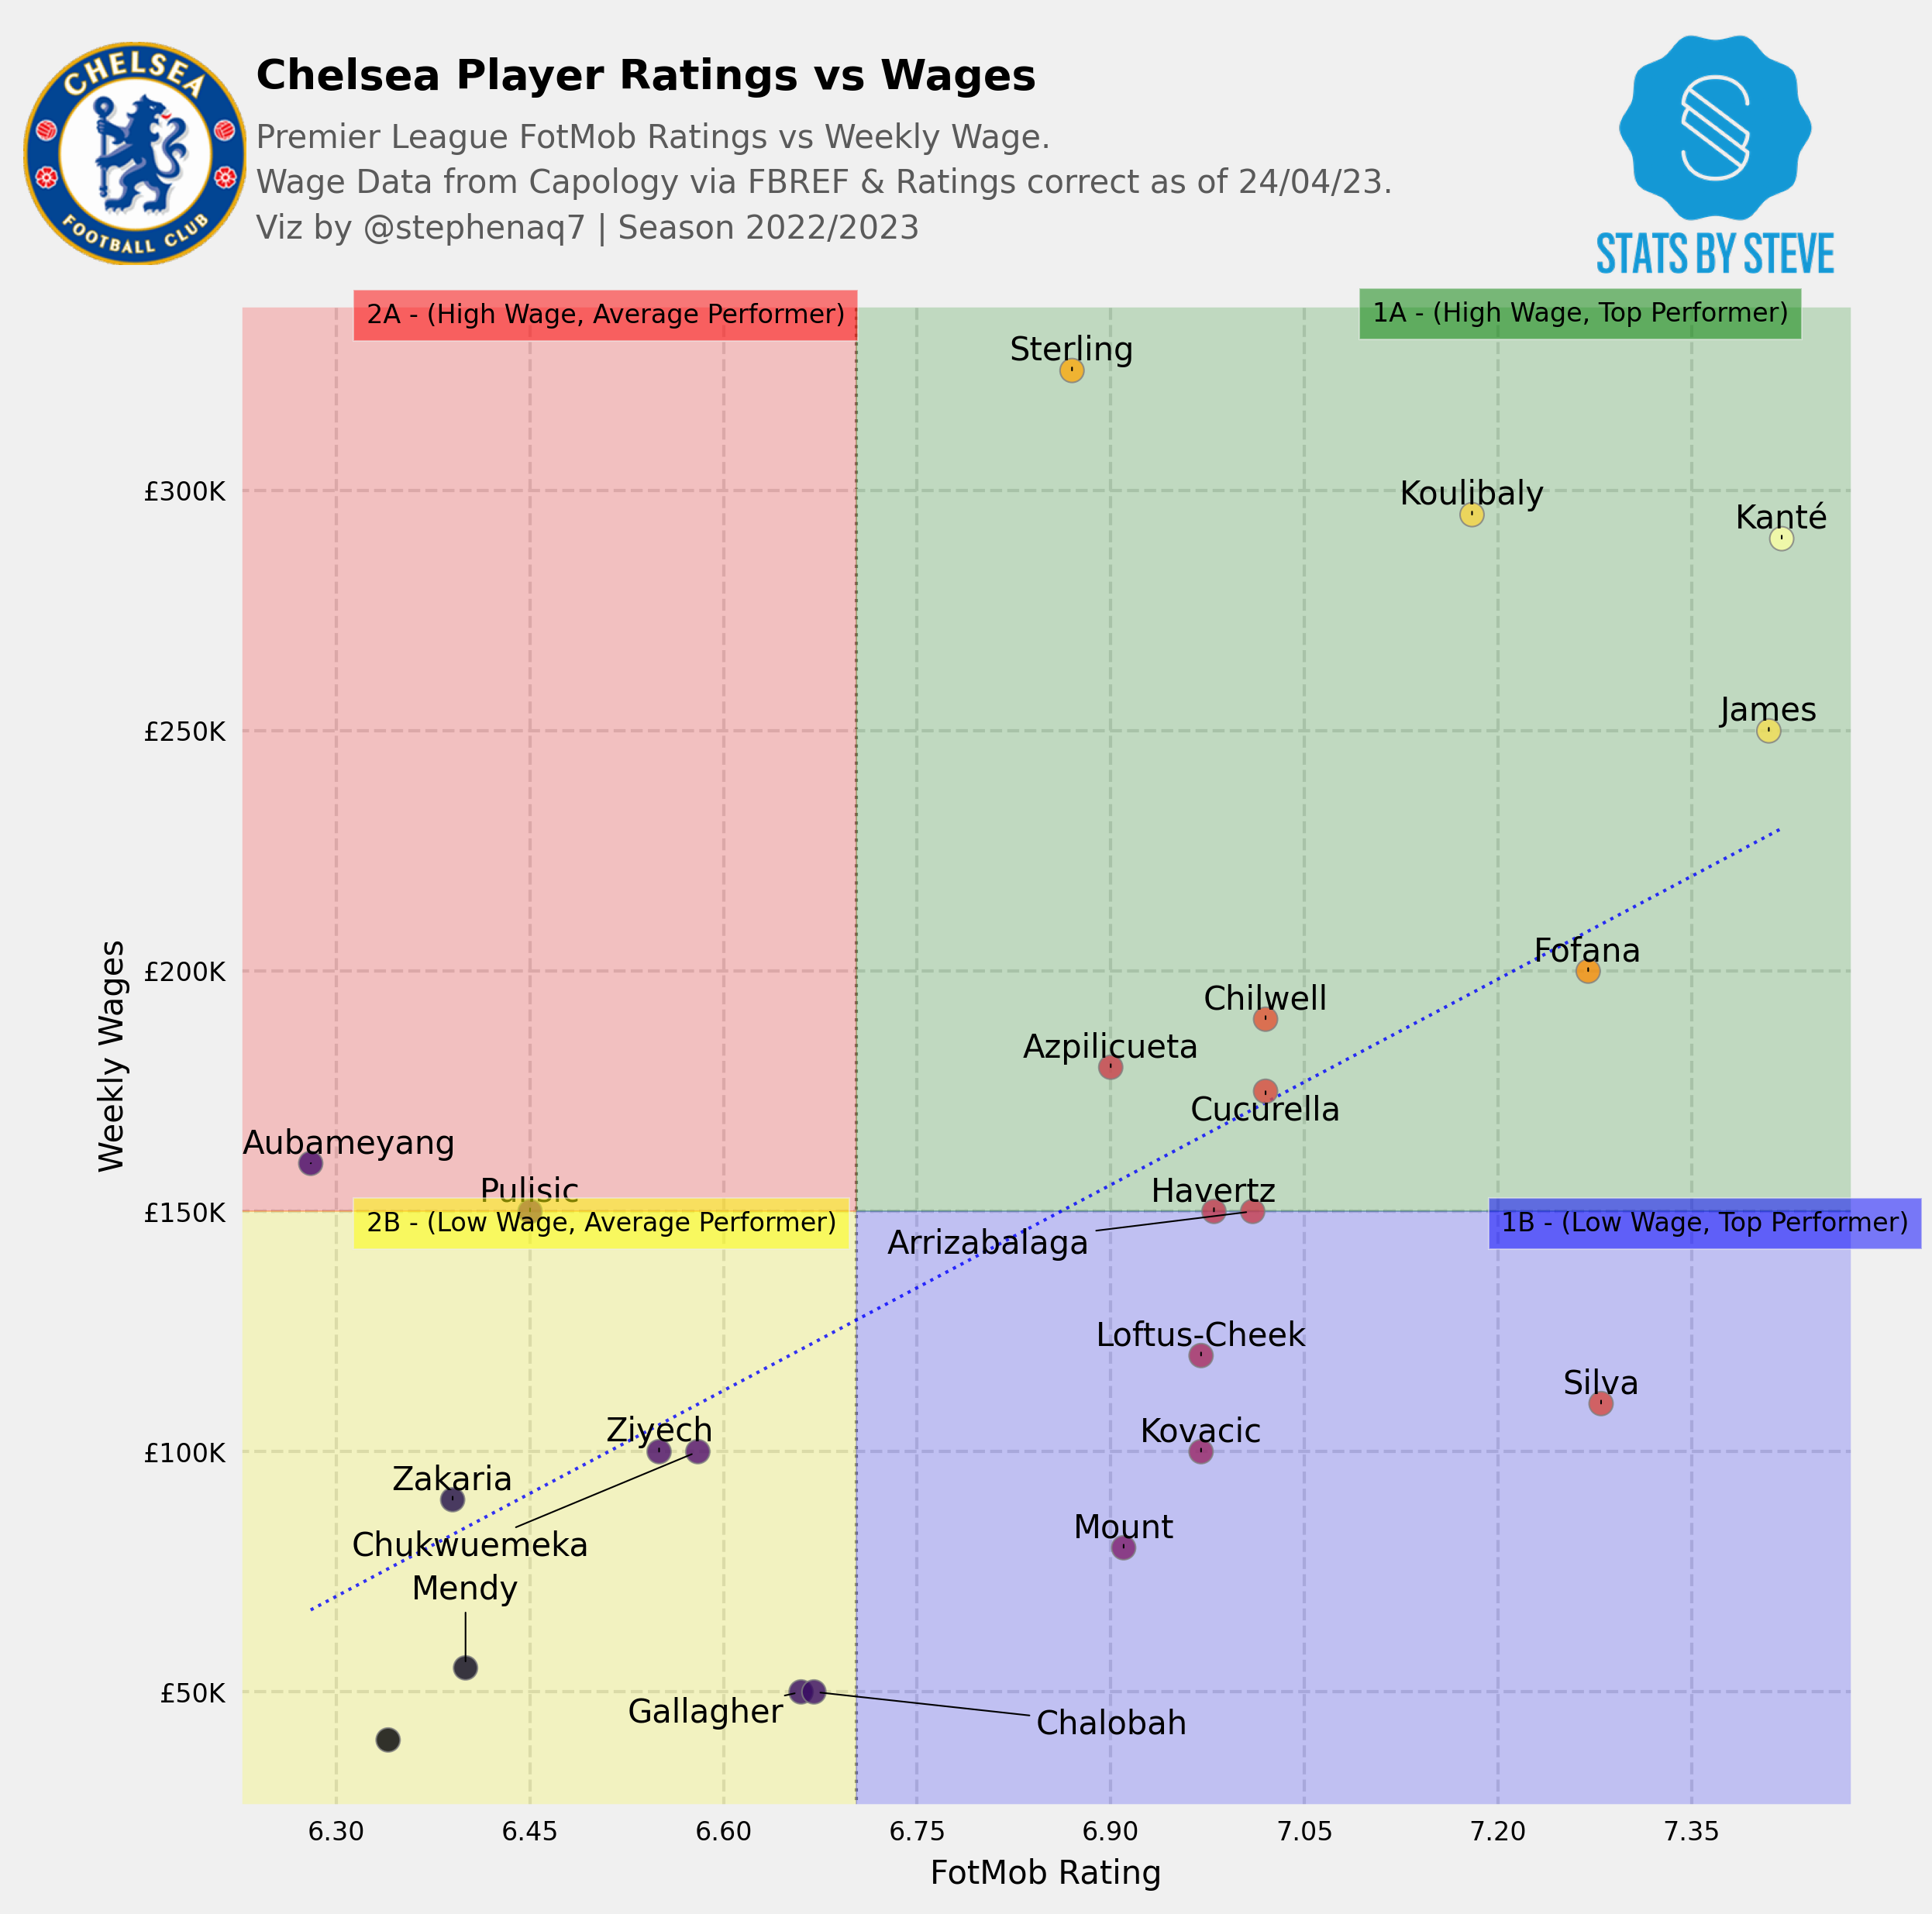

In [151]:


# Define a custom formatter for y-axis tick labels
max_ = max(abs(filtered_df['new_pound_value_2'].min()), filtered_df['new_pound_value_2'].max())

fig = plt.figure(figsize=(8, 8), dpi=300)
ax = plt.subplot()
ax.grid(visible=False, ls='--', color='lightgrey')

# Define quadrants based on median values of 'ratings' and 'new_pound_value_2'
median_ratings = ((filtered_df['ratings'].median())*0.97)
median_wages = filtered_df['new_pound_value_2'].median()

# Plot scatter points for each quadrant
scatter = ax.scatter(
    filtered_df['ratings'], filtered_df['new_pound_value_2'],
    c=filtered_df['zscore'], cmap='inferno',
    zorder=3, ec='grey', s=55, alpha=0.8)

texts = []
annotated_df = filtered_df[filtered_df['annotated']].reset_index(drop=True)
for index in range(annotated_df.shape[0]):
    # Extract last name from 'Name' column by splitting on space and taking the last element
    last_name = annotated_df['Name'].iloc[index].split()[-1]
    texts += [
        ax.text(
            x=annotated_df['ratings'].iloc[index], y=annotated_df['new_pound_value_2'].iloc[index],
            s=f"{last_name}",
            color='black',
            family='DM Sans', weight='light', fontsize=10 
        )
    ]

# Use adjust_text function to move overlapping texts
adjust_text(texts, force_text=(2, 2),
            arrowprops=dict(arrowstyle='-',color='black'),
            autoalign='y',
            only_move={'points':'y'})


# Add dotted line to separate quadrants
ax.axvline(median_ratings, linestyle='dotted', color='grey', lw=1, zorder=0)
ax.axhline(median_wages, linestyle='dotted', color='grey', lw=1, zorder=0)


# Set x-axis and y-axis limits to be equal
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]])
ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1]])

# Fill quadrants with transparent colors
ax.fill_between(
    [ax.get_xlim()[0], median_ratings],
    ax.get_ylim()[0], median_wages,
    color='yellow', alpha=0.2
)
ax.fill_between(
    [median_ratings, ax.get_xlim()[1]],
    ax.get_ylim()[0], median_wages,
    color='blue', alpha=0.2
)
ax.fill_between(
    [ax.get_xlim()[0], median_ratings],
    median_wages, ax.get_ylim()[1],
    color='red', alpha=0.2
)
ax.fill_between(
    [median_ratings, ax.get_xlim()[1]],
    median_wages, ax.get_ylim()[1],
    color='green', alpha=0.2
)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=False, prune='both'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'£{x:.0f}K'))
ax.tick_params(axis='both', labelsize=8)  # Updated fontsize to 8

ax.set_ylabel('Weekly Wages', fontsize=10)  # Set y-axis label with font size
ax.set_xlabel('FotMob Rating', fontsize=10)

ax.text(ax.get_xlim()[0] + 0.1, ax.get_ylim()[1] - 0.1,
        '2A - (High Wage, Average Performer)',
        bbox=dict(facecolor='red', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')
ax.text(ax.get_xlim()[0] + 0.1, median_wages + 0.1,
        '2B - (Low Wage, Average Performer)',
        bbox=dict(facecolor='yellow', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')
ax.text(median_ratings + 0.4, ax.get_ylim()[1] + 0.15,
        '1A - (High Wage, Top Performer)',
        bbox=dict(facecolor='green', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')
ax.text(median_ratings + 0.5, median_wages + 0.1,
        '1B - (Low Wage, Top Performer)',
        bbox=dict(facecolor='blue', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')

coefficients = np.polyfit(filtered_df['ratings'], filtered_df['new_pound_value_2'], 1)
p = np.poly1d(coefficients)
x_regression = np.linspace(np.min(filtered_df['ratings']), np.max(filtered_df['ratings']), 100)
y_regression = p(x_regression)

# Plot the regression line
ax.plot(x_regression, y_regression, c='b', label='Regression Line', linewidth=1, linestyle=':', alpha=0.8)




ax3 = fig.add_axes([0.78, 0.89, 0.19, 0.14])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/logo_transparent_background.png')
ax3.imshow(img)




fig_text(
    x=0.09, y=.99,
    s="Chelsea Player Ratings vs Wages",
    va="bottom", ha="left",
    fontsize= 13, color="black", font="DM Sans", weight="bold"
)
fig_text(
    x=0.09, y=0.91,
    s="Premier League FotMob Ratings vs Weekly Wage.\nWage Data from Capology via FBREF & Ratings correct as of 24/04/23.\nViz by @stephenaq7 | Season 2022/2023",
    va="bottom", ha="left",
    fontsize=10, color="#5A5A5A", font="Karla"
)
fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"

logo_ax = fig.add_axes([-0.08, .90, 0.21, 0.12], zorder=1)
club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{t_id}.png"))
logo_ax.imshow(club_icon)
logo_ax.axis("off")


plt.show()


In [168]:
# 8455

t_id = 8463
filtered_df = merged_df[merged_df['team_id'] == 8463]
filtered_df['player_id'] = filtered_df['URL'].str.extract(r'(\d+)')
filtered_df = filtered_df[filtered_df['ratings'].notna()]

total_wages = filtered_df['new_pound_value'].sum()

# Calculate wage contribution percentage
filtered_df['wage_contribution'] = (filtered_df['new_pound_value'] / total_wages)
filtered_df


filtered_df['new_pound_value_2'] = filtered_df['new_pound_value']/1000

filtered_df['zscore'] = stats.zscore(filtered_df['new_pound_value_2'])*1 + stats.zscore(filtered_df['ratings'])*1
filtered_df['annotated'] = [True if x > filtered_df['zscore'].quantile(0) else False for x in filtered_df['zscore']]


def pound_formatter(x, pos):
    return f'£{x/1000:.0f}K'

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  


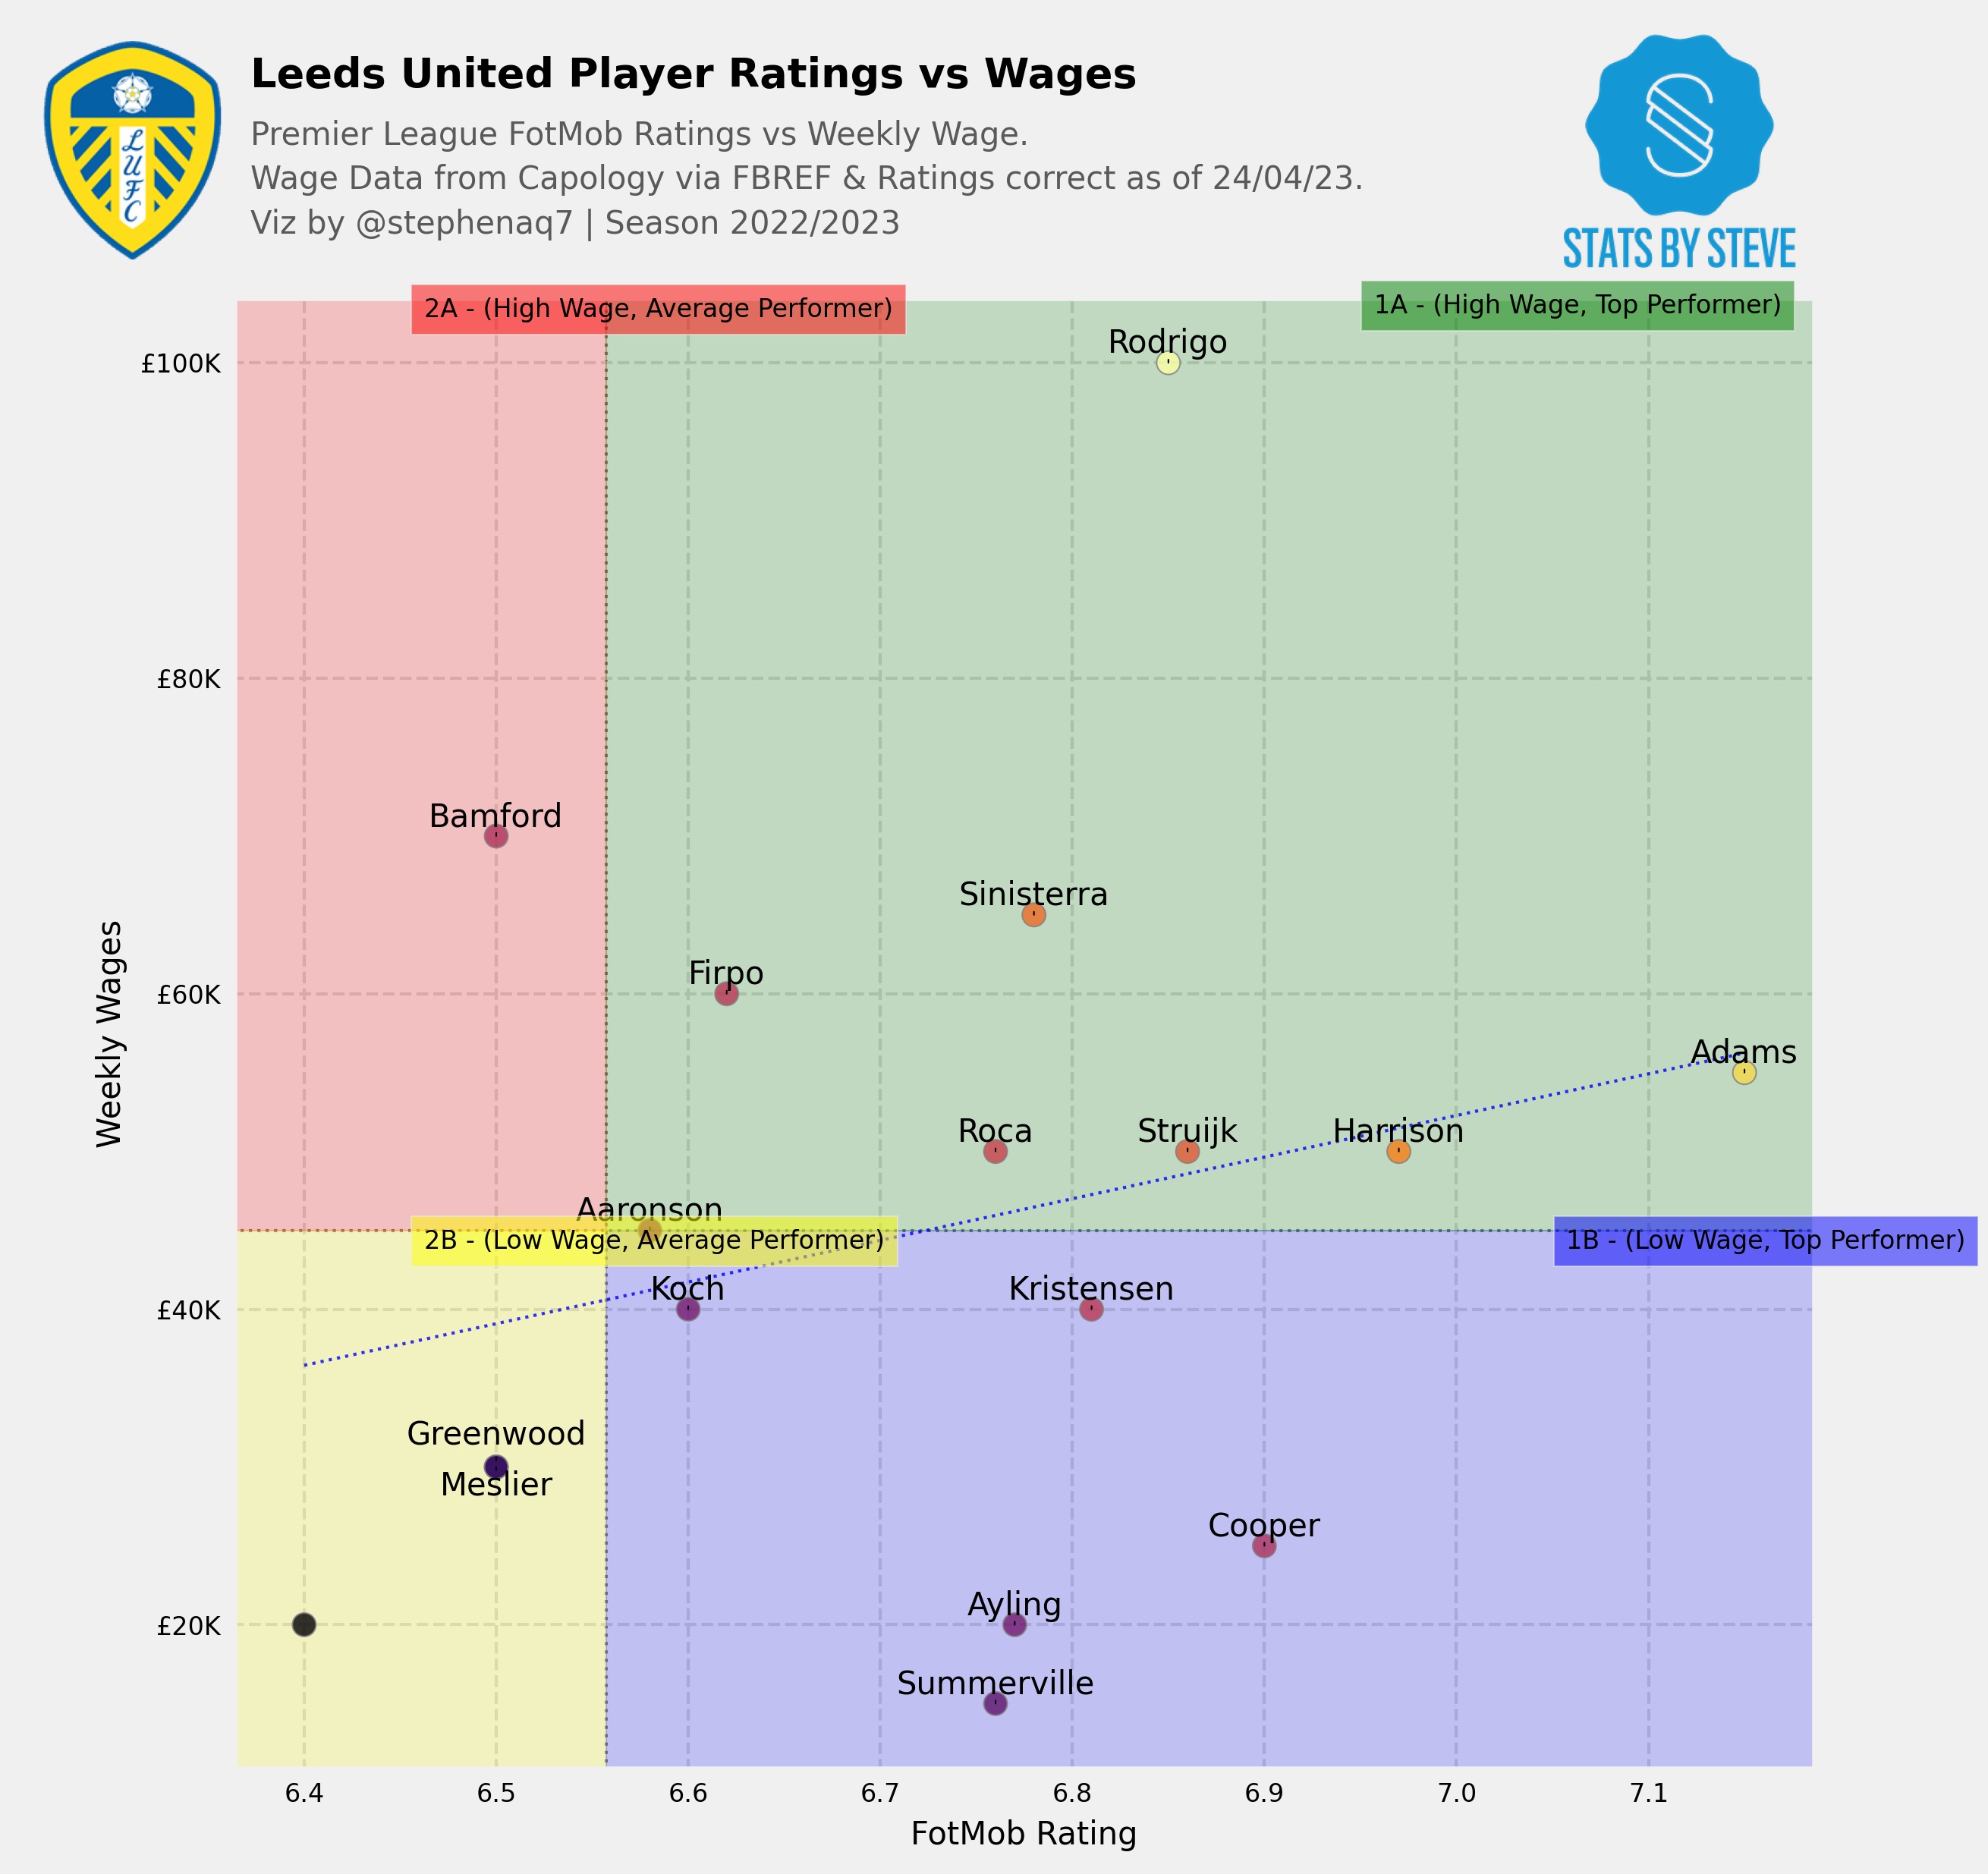

In [171]:


# Define a custom formatter for y-axis tick labels
max_ = max(abs(filtered_df['new_pound_value_2'].min()), filtered_df['new_pound_value_2'].max())

fig = plt.figure(figsize=(8, 8), dpi=300)
ax = plt.subplot()
ax.grid(visible=False, ls='--', color='lightgrey')

# Define quadrants based on median values of 'ratings' and 'new_pound_value_2'
median_ratings = ((filtered_df['ratings'].median())*0.97)
median_wages = filtered_df['new_pound_value_2'].median()

# Plot scatter points for each quadrant
scatter = ax.scatter(
    filtered_df['ratings'], filtered_df['new_pound_value_2'],
    c=filtered_df['zscore'], cmap='inferno',
    zorder=3, ec='grey', s=55, alpha=0.8)

texts = []
annotated_df = filtered_df[filtered_df['annotated']].reset_index(drop=True)
for index in range(annotated_df.shape[0]):
    # Extract last name from 'Name' column by splitting on space and taking the last element
    last_name = annotated_df['Name'].iloc[index].split()[-1]
    texts += [
        ax.text(
            x=annotated_df['ratings'].iloc[index], y=annotated_df['new_pound_value_2'].iloc[index],
            s=f"{last_name}",
            color='black',
            family='DM Sans', weight='light', fontsize=10 
        )
    ]

# Use adjust_text function to move overlapping texts
adjust_text(texts, force_text=(2, 2),
            arrowprops=dict(arrowstyle='-',color='black'),
            autoalign='y',
            only_move={'points':'y'})


# Add dotted line to separate quadrants
ax.axvline(median_ratings, linestyle='dotted', color='grey', lw=1, zorder=0)
ax.axhline(median_wages, linestyle='dotted', color='grey', lw=1, zorder=0)


# Set x-axis and y-axis limits to be equal
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]])
ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1]])

# Fill quadrants with transparent colors
ax.fill_between(
    [ax.get_xlim()[0], median_ratings],
    ax.get_ylim()[0], median_wages,
    color='yellow', alpha=0.2
)
ax.fill_between(
    [median_ratings, ax.get_xlim()[1]],
    ax.get_ylim()[0], median_wages,
    color='blue', alpha=0.2
)
ax.fill_between(
    [ax.get_xlim()[0], median_ratings],
    median_wages, ax.get_ylim()[1],
    color='red', alpha=0.2
)
ax.fill_between(
    [median_ratings, ax.get_xlim()[1]],
    median_wages, ax.get_ylim()[1],
    color='green', alpha=0.2
)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=False, prune='both'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'£{x:.0f}K'))
ax.tick_params(axis='both', labelsize=8)  # Updated fontsize to 8

ax.set_ylabel('Weekly Wages', fontsize=10)  # Set y-axis label with font size
ax.set_xlabel('FotMob Rating', fontsize=10)

ax.text(ax.get_xlim()[0] + 0.1, ax.get_ylim()[1] - 0.1,
        '2A - (High Wage, Average Performer)',
        bbox=dict(facecolor='red', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')
ax.text(ax.get_xlim()[0] + 0.1, median_wages + 0.1,
        '2B - (Low Wage, Average Performer)',
        bbox=dict(facecolor='yellow', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')
ax.text(median_ratings + 0.4, ax.get_ylim()[1] + 0.15,
        '1A - (High Wage, Top Performer)',
        bbox=dict(facecolor='green', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')
ax.text(median_ratings + 0.5, median_wages + 0.1,
        '1B - (Low Wage, Top Performer)',
        bbox=dict(facecolor='blue', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')

coefficients = np.polyfit(filtered_df['ratings'], filtered_df['new_pound_value_2'], 1)
p = np.poly1d(coefficients)
x_regression = np.linspace(np.min(filtered_df['ratings']), np.max(filtered_df['ratings']), 100)
y_regression = p(x_regression)

# Plot the regression line
ax.plot(x_regression, y_regression, c='b', label='Regression Line', linewidth=1, linestyle=':', alpha=0.8)




ax3 = fig.add_axes([0.78, 0.89, 0.19, 0.14])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/logo_transparent_background.png')
ax3.imshow(img)




fig_text(
    x=0.09, y=.99,
    s="Leeds United Player Ratings vs Wages",
    va="bottom", ha="left",
    fontsize= 13, color="black", font="DM Sans", weight="bold"
)
fig_text(
    x=0.09, y=0.91,
    s="Premier League FotMob Ratings vs Weekly Wage.\nWage Data from Capology via FBREF & Ratings correct as of 24/04/23.\nViz by @stephenaq7 | Season 2022/2023",
    va="bottom", ha="left",
    fontsize=10, color="#5A5A5A", font="Karla"
)
fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"

logo_ax = fig.add_axes([-0.08, .90, 0.21, 0.12], zorder=1)
club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{t_id}.png"))
logo_ax.imshow(club_icon)
logo_ax.axis("off")


plt.show()


In [172]:
grouped_df = merged_df.groupby('team_id').agg({'new_pound_value': 'sum', 'ratings': 'mean'})

# Rank the columns 'new_pound_value' and 'ratings'
grouped_df['new_pound_value_rank'] = grouped_df['new_pound_value'].rank(ascending=False)
grouped_df['ratings_rank'] = grouped_df['ratings'].rank(ascending=False)

# Reset the index to bring back 'team_id' as a column
grouped_df = grouped_df.reset_index()

# Pivot the table to show rankings as columns
pivot_table = pd.pivot_table(grouped_df, index='team_id', values=['new_pound_value_rank', 'ratings_rank'])


In [175]:
team_names = pd.read_csv("CSVs/fotmob_epl_team_ids.csv")
pivot_table= pivot_table.reset_index()
wage_vs_rating = pd.merge(pivot_table, team_names, on='team_id')

In [179]:
wage_vs_rating = wage_vs_rating[["team", "team_id",	"new_pound_value_rank",	"ratings_rank"]]


In [180]:
wage_vs_rating

,team,team_id,new_pound_value_rank,ratings_rank
0,Leicester City,8197,11.0,13.0
1,Chelsea,8455,3.0,8.0
2,Manchester City,8456,2.0,2.0
3,Leeds United,8463,17.0,16.0
4,Southampton,8466,15.0,18.0
5,Tottenham,8586,5.0,6.0
6,Wolves,8602,14.0,17.0
7,Liverpool,8650,4.0,4.0
8,West Ham,8654,7.0,15.0
9,Everton,8668,9.0,11.0


(-0.5, 191.5, 191.5, -0.5)

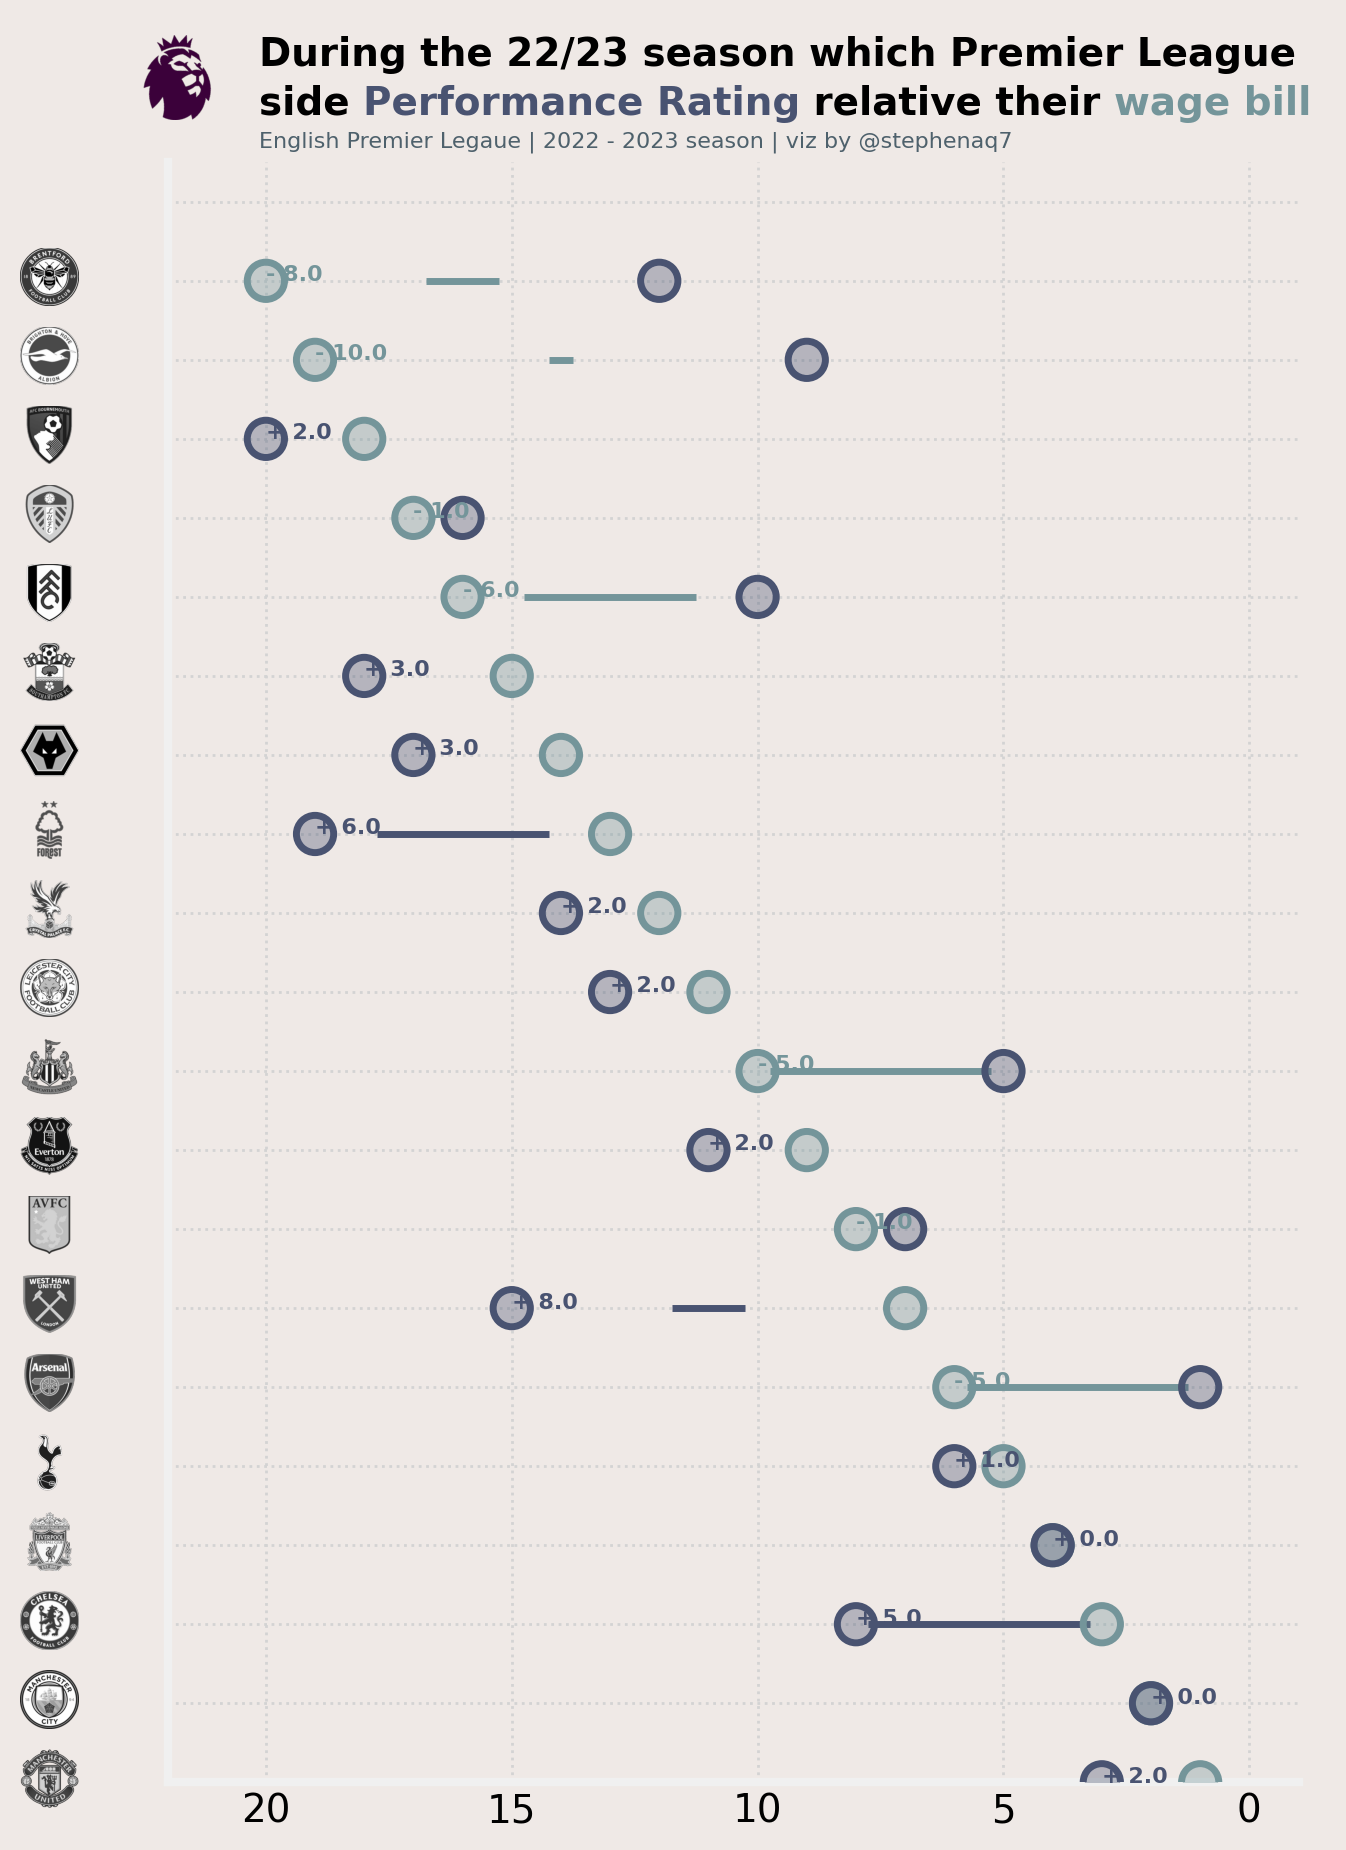

In [209]:
#%%
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
from matplotlib import rcParams
import numpy as np
from highlight_text import fig_text
import pandas as pd

from PIL import Image
import urllib
import os

wage_vs_rating = wage_vs_rating.sort_values(by=['new_pound_value_rank'])


fig = plt.figure(figsize=(6.5, 10), dpi = 200, facecolor="#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")

# Adjust spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.grid(True, color = "lightgrey", ls = ":")



# Define the series
teams = list(wage_vs_rating["team_id"].unique())
Y = np.arange(len(teams))
X_wage = wage_vs_rating["new_pound_value_rank"]
X_rating = wage_vs_rating["ratings_rank"]

# Fix axes limits
ax.set_ylim(0, len(teams) + 0.5)
ax.set_xlim(
    max(X_wage.max(), X_rating.max()) + 2, # Add 1 to provide some margin on the right
    min(X_wage.min(), X_rating.min()) - 2  # Subtract 1 to provide some margin on the left
       
)

# Scatter plots
ax.scatter(X_wage, Y, color = "#74959A", s = 150, alpha = 0.35, zorder = 3)
ax.scatter(X_rating, Y, color = "#495371", s = 150, alpha = 0.35, zorder = 3)
ax.scatter(X_wage, Y, color = "none", ec = "#74959A", s = 180, lw = 2.5, zorder = 3)
ax.scatter(X_rating, Y, color = "none", ec = "#495371", s = 180, lw = 2.5, zorder = 3)


# Add line chart between points and difference annotation
for index in Y:
    difference = X_wage.iloc[index] - X_rating.iloc[index]
    if difference > 0:
        color = "#74959A" 
        x_adj = -4.75
        anot_position = X_wage.iloc[index]
        anot_aux_sign = "-"
    else:
        color = "#495371"
        x_adj = 4.75
        anot_position = X_rating.iloc[index]
        anot_aux_sign = "+"
    
    ax.annotate(
        xy = (anot_position, index),
        text = f"{anot_aux_sign} {abs(difference):.1f}",
        xytext = (0, 0),  # Update this line
        textcoords = "offset points",
        size = 8,
        color = color,
        weight = "bold"
)
    
    if abs(difference) < 3.5:
        continue
    ax.plot(
        [X_wage.iloc[index] + x_adj, X_rating.iloc[index] + x_adj*(-1)],
        [index, index],
        lw = 2.5,
        color = color,
        zorder = 2
    )

# Native data to figure coordinates
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

# Define logo size and position relative to the chart
logo_size = 0.045
logo_x_offset = 0.025
logo_y_offset = 0.02

for index, team_id in enumerate(teams):
    # ax_coords = DC_to_NFC([max(X_wage.max(), X_rating.max()) + logo_x_offset, index + 0.5 - logo_y_offset])
    ax_coords = DC_to_NFC([25, index - 0.52])

    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], logo_size, logo_size], anchor="C")
    club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")


# Remove tick labels
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
false_ticks = ax.set_yticklabels([])

fig_text(
    x = 0.15, y = .9, 
    s = "During the 22/23 season which Premier League \nside <Performance Rating> relative their <wage bill>",
    highlight_textprops = [
        {"color": "#495371"},
        {"color":"#74959A"}
    ],
    va = "bottom", ha = "left",
    fontsize = 14, color = "black", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.15, y = .885, 
    s = "English Premier Legaue | 2022 - 2023 season | viz by @stephenaq7",
	va = "bottom", ha = "left",
	fontsize = 8, color = "#4E616C", font = "Karla"
)

# # ---- The League's logo
league_icon = Image.open(urllib.request.urlopen(f"https://images.fotmob.com/image_resources/logo/leaguelogo/47.png"))
league_ax = fig.add_axes([0.055, 0.89, 0.065, 0.065], zorder=1)
league_ax.imshow(league_icon)
league_ax.axis("off")

